In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'USD'
share_name = 'YAR.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [4]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2009-03-31,2496,-1992,504,132,624,1388,2187,4668,0,...,11003,0,0,833,2422,3002,6755,618,-350,289
1,2009-06-30,2488,-2146,341,175,319,1188,1638,3473,0,...,10397,0,0,717,2071,2474,5882,658,-181,289
2,2009-09-30,2352,-2012,340,58,180,1008,1518,3064,0,...,10617,0,0,957,2377,1980,5818,426,-199,289
3,2009-12-31,2425,-1969,456,250,168,1024,1356,3171,0,...,10644,0,0,564,2043,2405,5689,196,-239,289
4,2010-03-31,2669,-1925,743,262,175,1208,1376,3263,0,...,10828,0,0,511,2145,2230,5608,413,-194,288


## Calculate date when quaterly reports could be available

In [5]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [6]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
55,2022-12-31,2023-02-11,254,5437,-3893,1544,766,1010,2305,4365,...,112,17982,0,157,172,4338,3597,9395,1013,-282
56,2023-03-31,2023-04-21,254,4136,-3282,854,105,1188,2096,4039,...,132,17652,0,173,175,3863,3576,8915,503,-269
57,2023-06-30,2023-07-21,254,3940,-3286,654,-298,626,1944,3338,...,132,16211,0,477,159,3963,3550,9032,677,-270
58,2023-09-30,2023-10-21,254,3850,-3054,796,2,868,1710,2794,...,129,15665,0,141,160,3515,3518,8523,1015,-299
59,2023-12-31,2024-02-11,254,3582,-2473,1109,246,539,1634,3058,...,135,16027,0,517,123,3714,3284,8457,93,-373


## Pull historical average USD national currency rates and add to the dataframe

In [7]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
55,2022-12-31,2023-02-11,254,5437,-3893,1544,766,1010,2305,4365,...,17982,0,157,172,4338,3597,9395,1013,-282,10.186402
56,2023-03-31,2023-04-21,254,4136,-3282,854,105,1188,2096,4039,...,17652,0,173,175,3863,3576,8915,503,-269,10.221379
57,2023-06-30,2023-07-21,254,3940,-3286,654,-298,626,1944,3338,...,16211,0,477,159,3963,3550,9032,677,-270,10.699984
58,2023-09-30,2023-10-21,254,3850,-3054,796,2,868,1710,2794,...,15665,0,141,160,3515,3518,8523,1015,-299,10.483742
59,2023-12-31,2024-02-11,254,3582,-2473,1109,246,539,1634,3058,...,16027,0,517,123,3714,3284,8457,93,-373,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [8]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
55,2022-12-31,2023-02-11,254,55383.465988,-39655.661779,15727.804209,7802.783695,10288.265707,23479.655895,44463.643377,...,183171.875189,0.0,1599.265065,1752.061091,44188.610531,36640.486879,95701.243877,10318.824912,-2872.565277,10.186402
56,2023-03-31,2023-04-21,254,42275.621929,-33546.564597,8729.057333,1073.244754,12142.997788,21424.009566,41284.148204,...,180427.775216,0.0,1768.298499,1788.741257,39485.185569,36551.649908,91123.590304,5141.353441,-2749.550846,10.221379
57,2023-06-30,2023-07-21,254,42157.935782,-35160.146442,6997.789341,-3188.595143,6698.189797,20800.768315,35716.545594,...,173457.435779,0.0,5103.892225,1701.297408,42404.035407,37984.942139,96642.252788,7243.888966,-2888.995599,10.699984
58,2023-09-30,2023-10-21,254,40362.406850,-32017.348187,8345.058663,20.967484,9099.888090,17927.198887,29291.575257,...,164227.819041,0.0,1478.207628,1677.398726,36850.353267,36881.804493,89352.933399,10640.998170,-3134.638870,10.483742
59,2023-12-31,2024-02-11,254,38761.190764,-26760.587594,12000.603171,2661.991326,5832.574490,17681.682219,33090.932819,...,173429.816968,0.0,5594.510225,1330.995663,40189.576354,35536.502085,91514.067642,1006.362574,-4036.271400,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [9]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [10]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [11]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [12]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2009-04-27,83.499893,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,0.386077,0.613923,7.193084,inf,16.0,3.643347,0.201923,0.052885,0.047987,0.124294
1,2009-05-04,90.497108,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,0.386077,0.613923,7.193084,inf,16.0,3.643347,0.201923,0.052885,0.047987,0.124294
2,2009-05-11,98.783981,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,0.386077,0.613923,7.193084,inf,16.0,3.643347,0.201923,0.052885,0.047987,0.124294
3,2009-05-18,102.959618,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,0.386077,0.613923,7.193084,inf,16.0,3.643347,0.201923,0.052885,0.047987,0.124294
4,2009-05-25,98.545349,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,0.386077,0.613923,7.193084,inf,16.0,3.643347,0.201923,0.052885,0.047987,0.124294


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [13]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2009-04-27,83.499893,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,3.643347,0.201923,0.052885,0.047987,0.124294,6.656323,0.827340,0.352017,0.966100,0.907680
1,2009-05-04,90.497108,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,3.643347,0.201923,0.052885,0.047987,0.124294,7.214117,0.896670,0.381516,0.995598,0.983743
2,2009-05-11,98.783981,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,3.643347,0.201923,0.052885,0.047987,0.124294,7.874718,0.978778,0.416451,1.030534,1.073825
3,2009-05-18,102.959618,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,3.643347,0.201923,0.052885,0.047987,0.124294,8.207585,1.020152,0.434055,1.048137,1.119216
4,2009-05-25,98.545349,2009-03-31,17137.996222,12.544448,100.925783,289.0,26585.865933,91.992616,4284.499055,...,3.643347,0.201923,0.052885,0.047987,0.124294,7.855695,0.976414,0.415445,1.029528,1.071231


# Calculate Dividend yield and currency-share price correlation

In [14]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

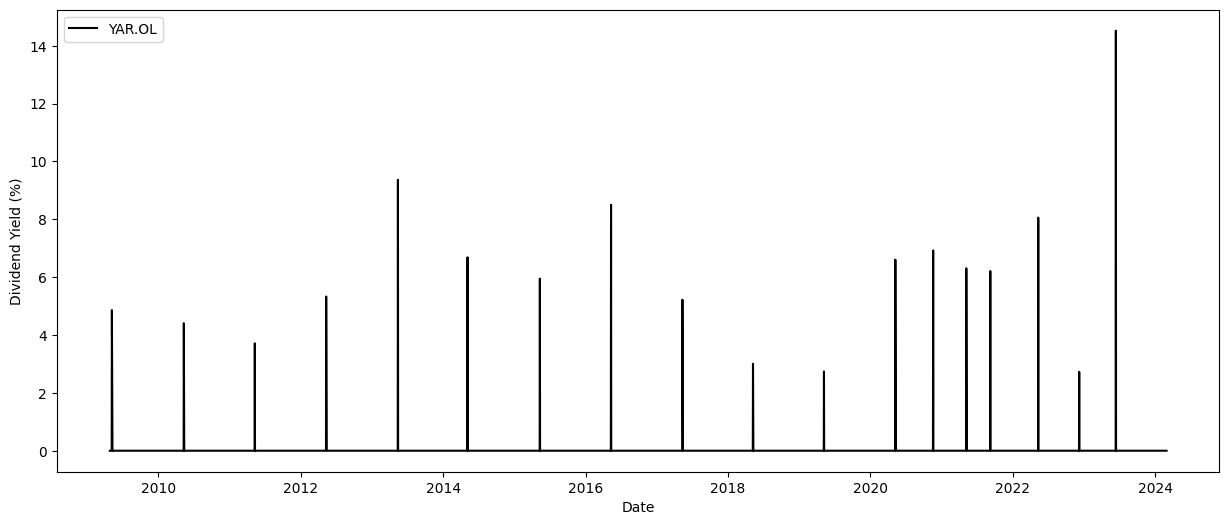

In [15]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.857569
share_price      1.000000
Name: share_price, dtype: float64


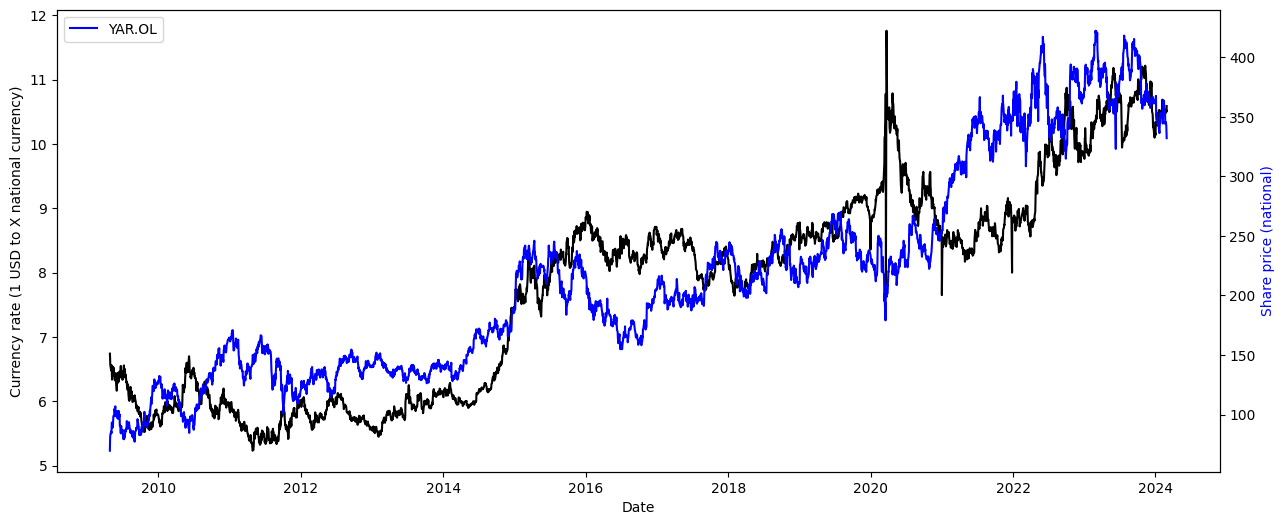

In [16]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

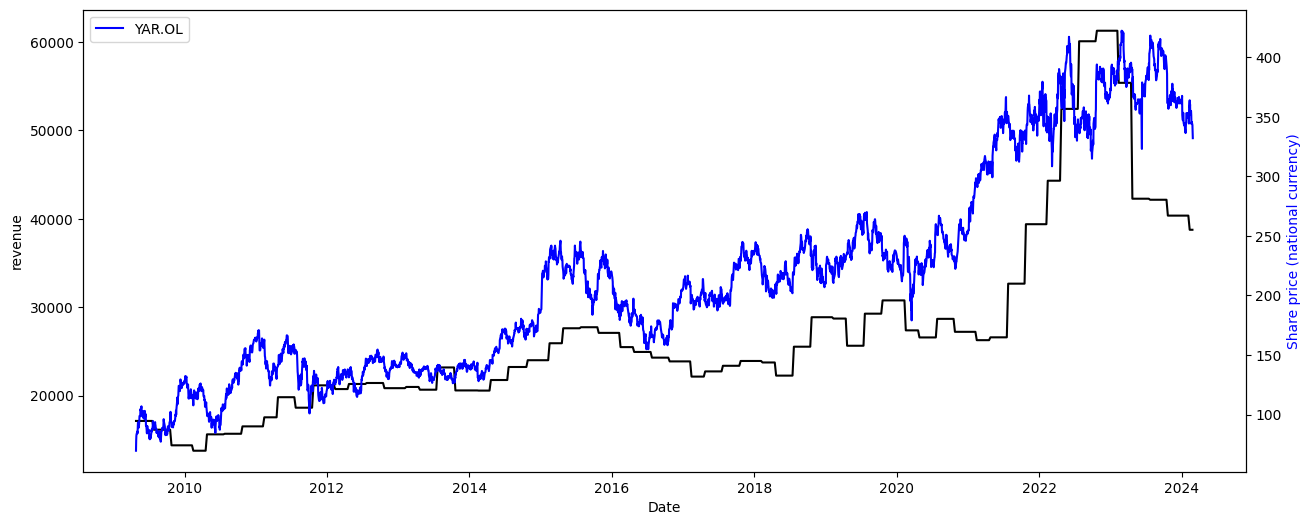

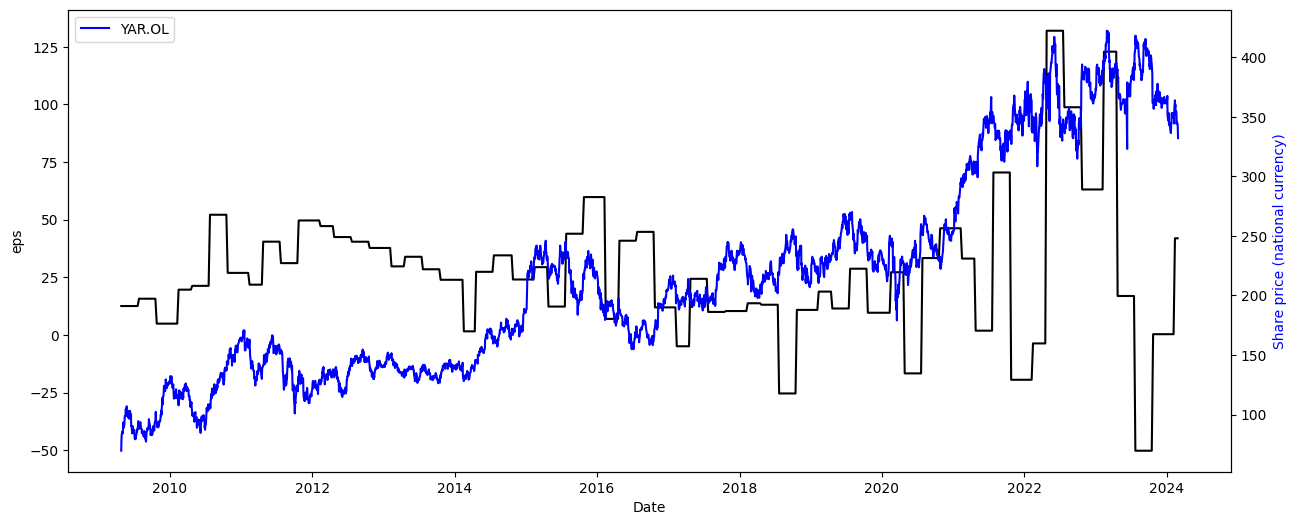

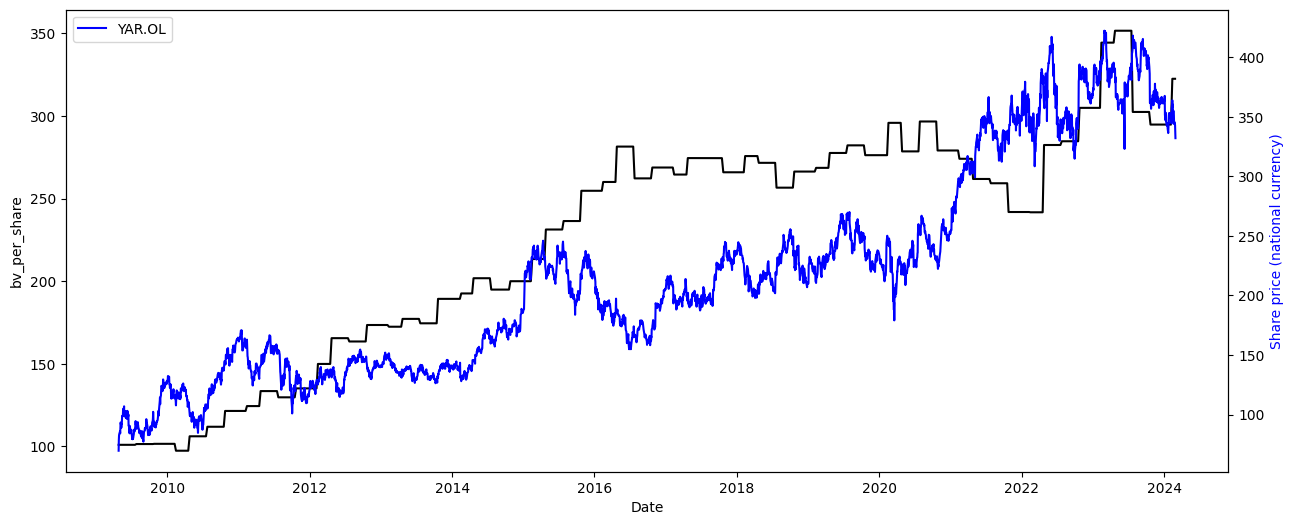

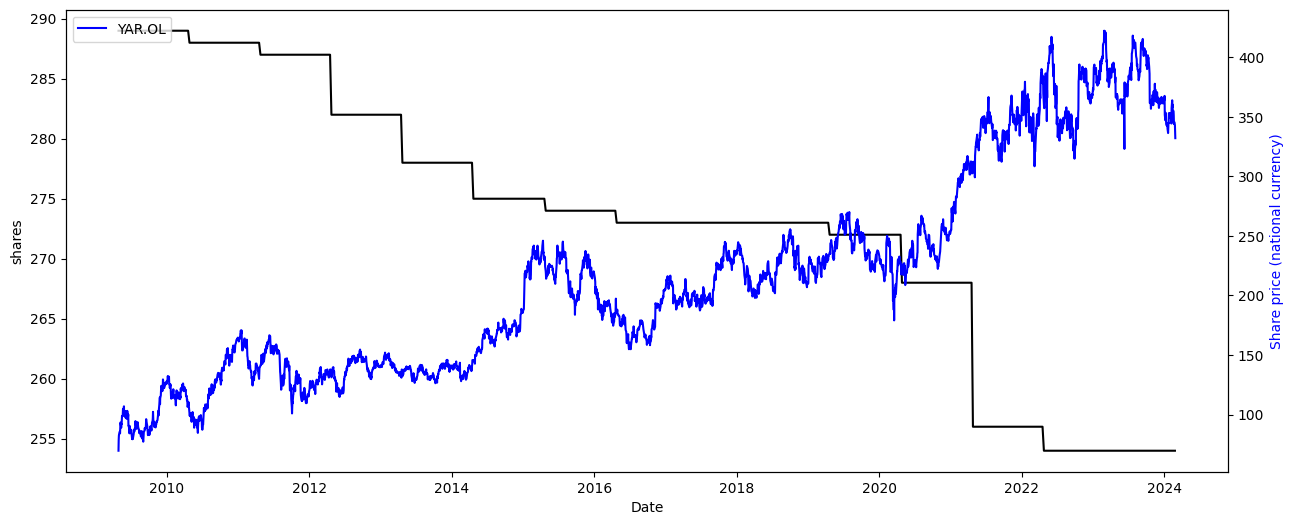

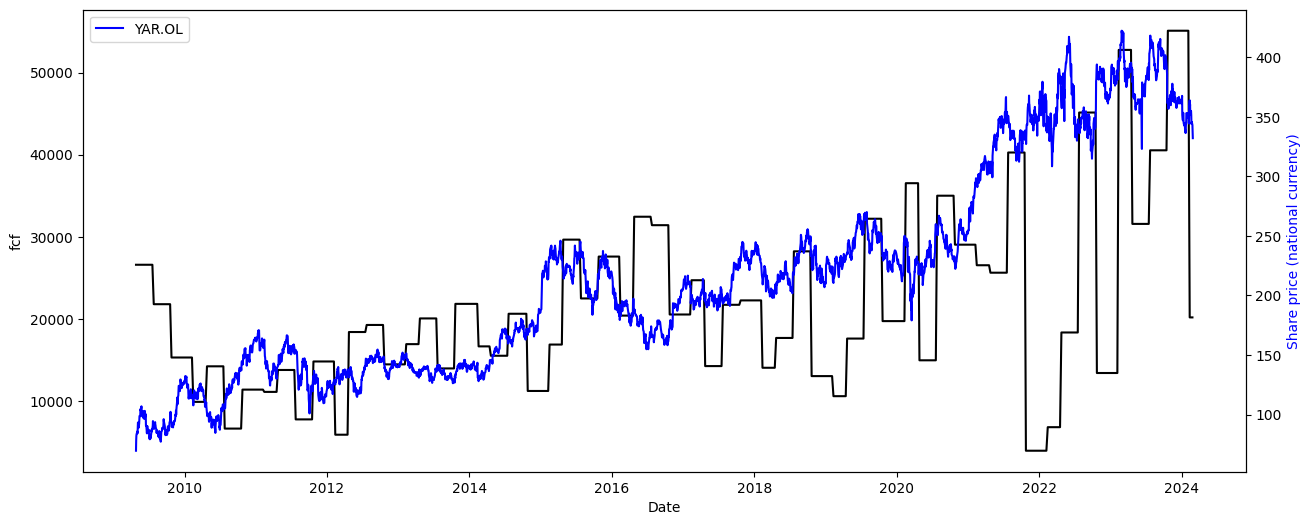

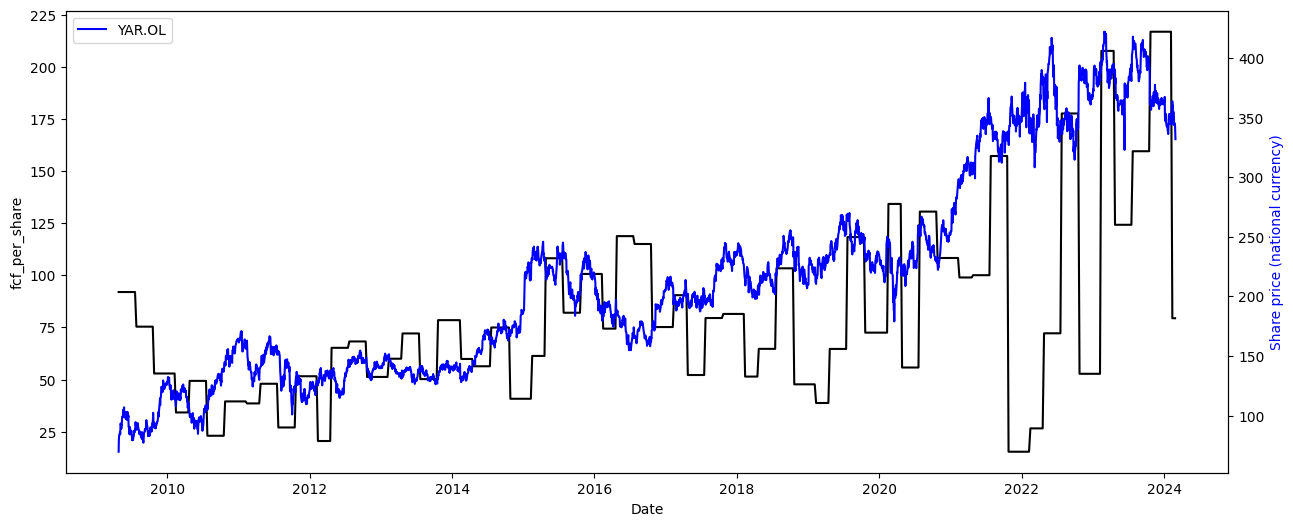

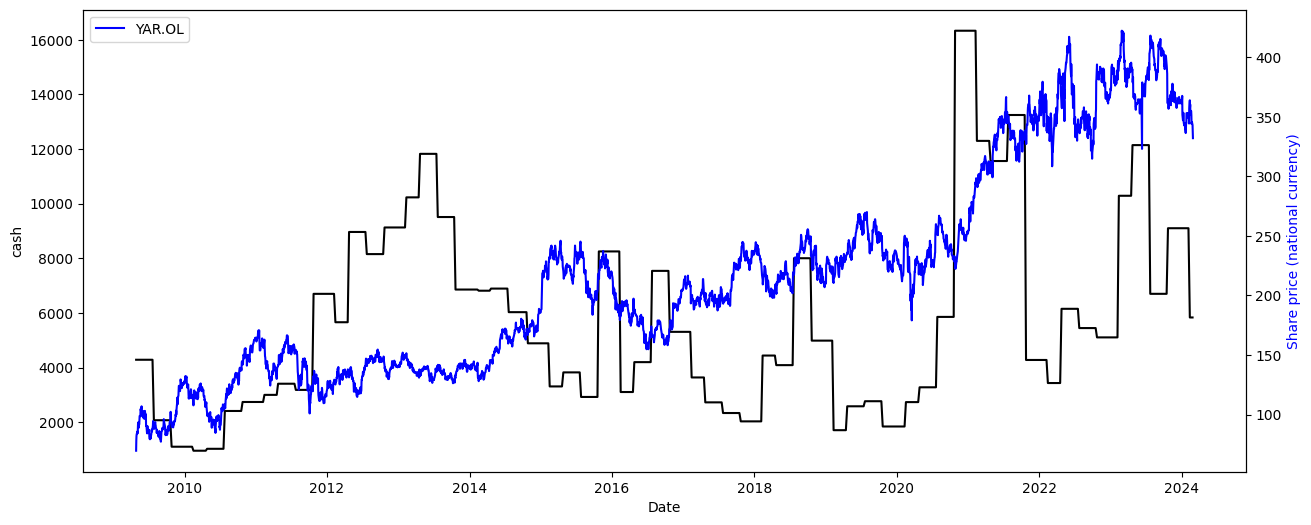

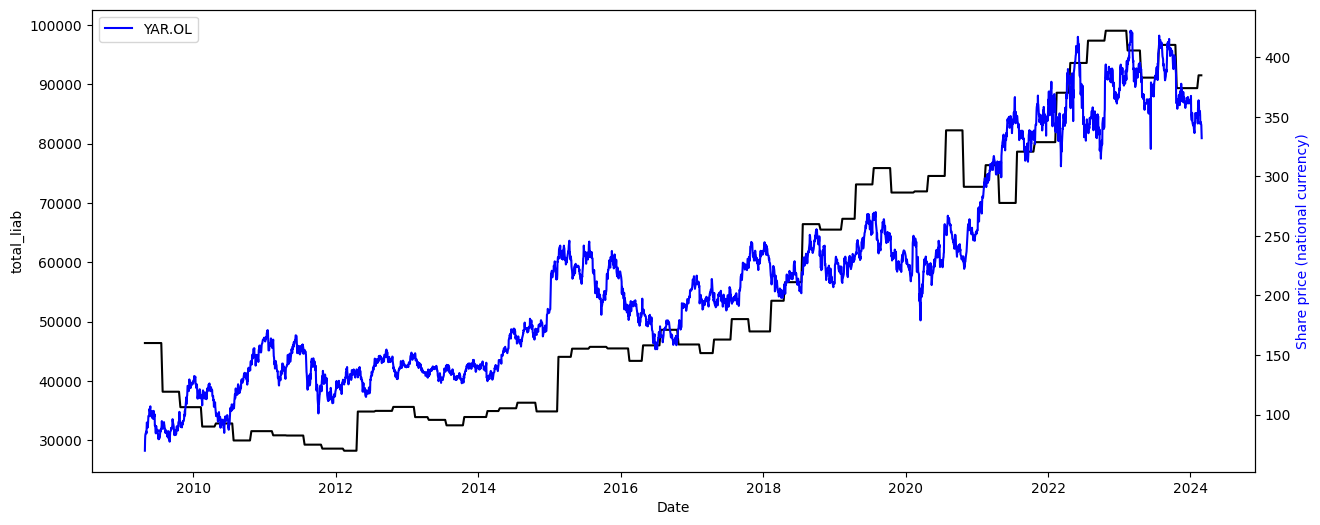

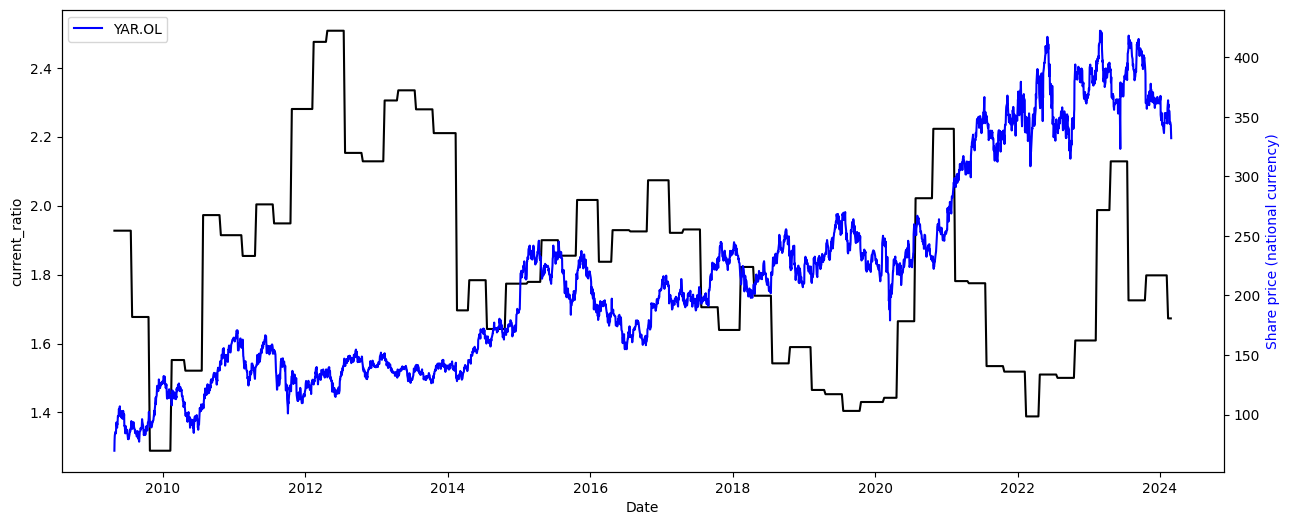

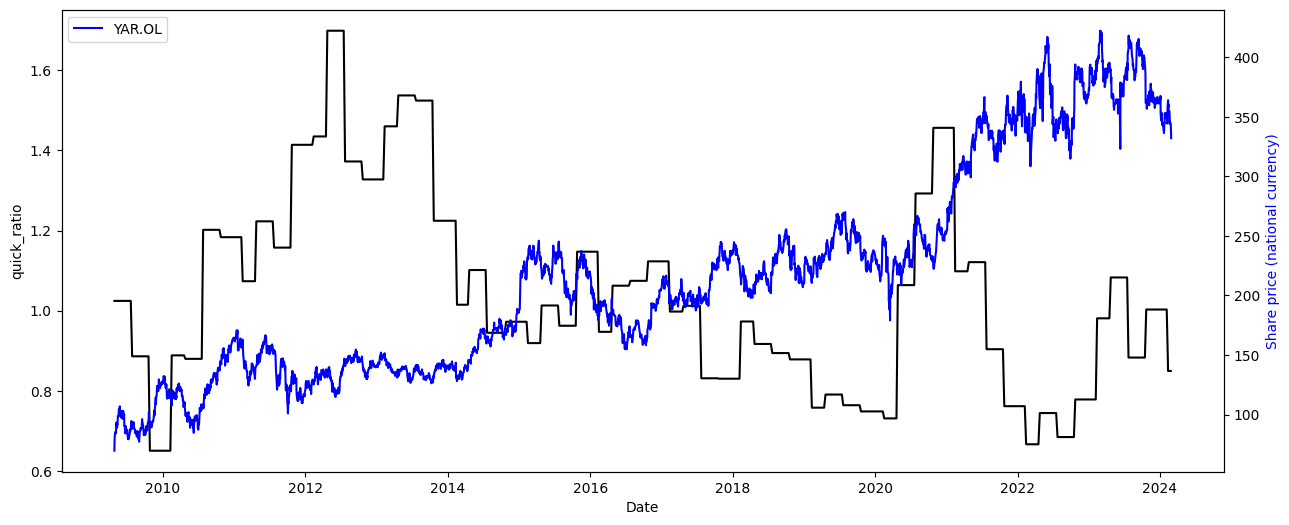

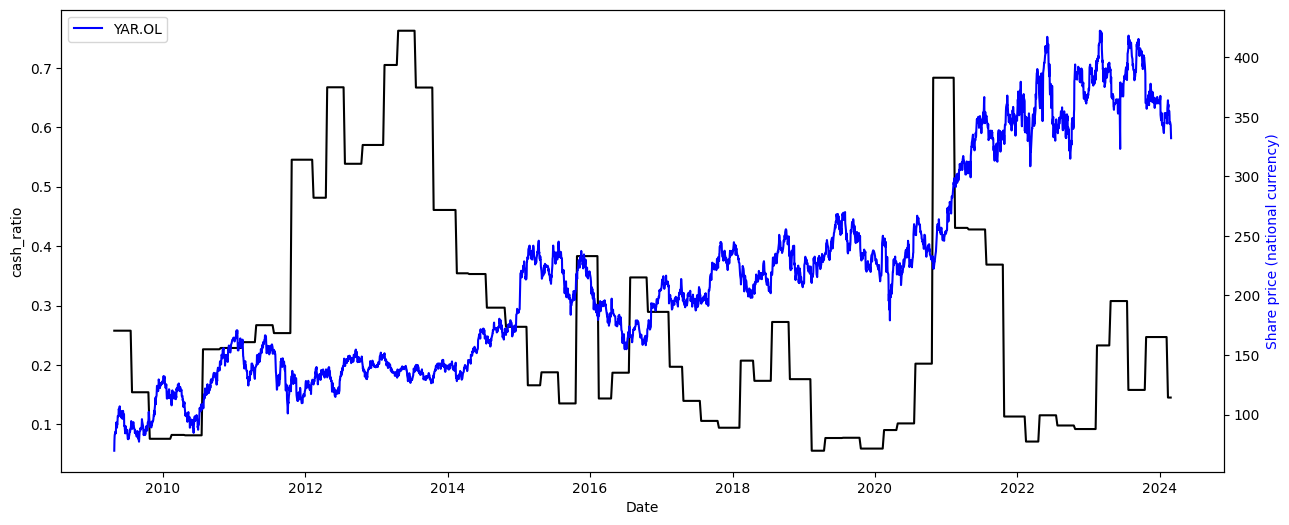

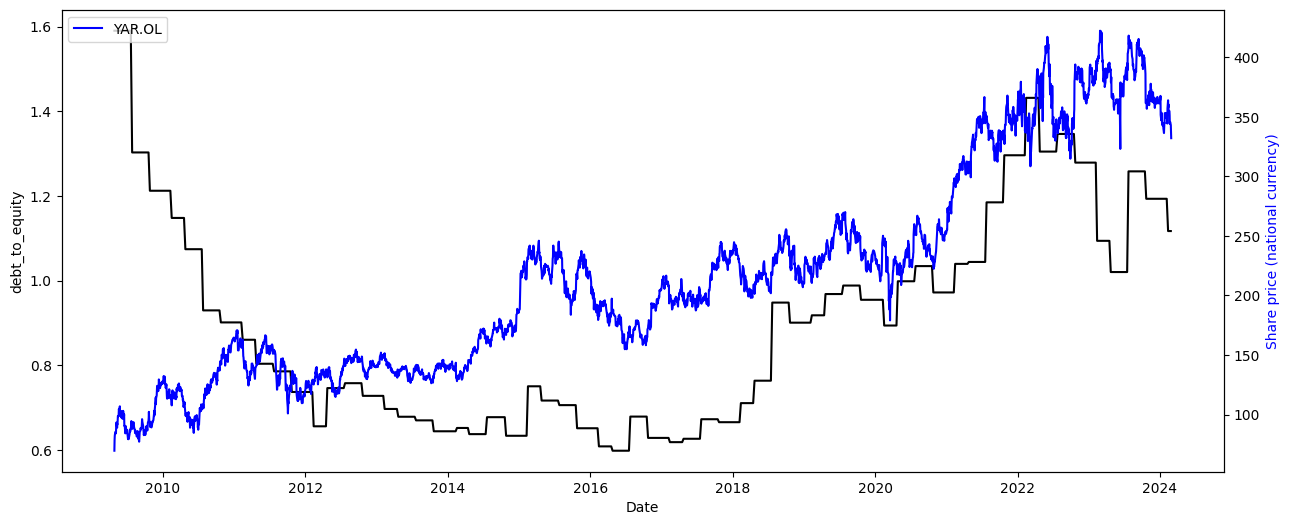

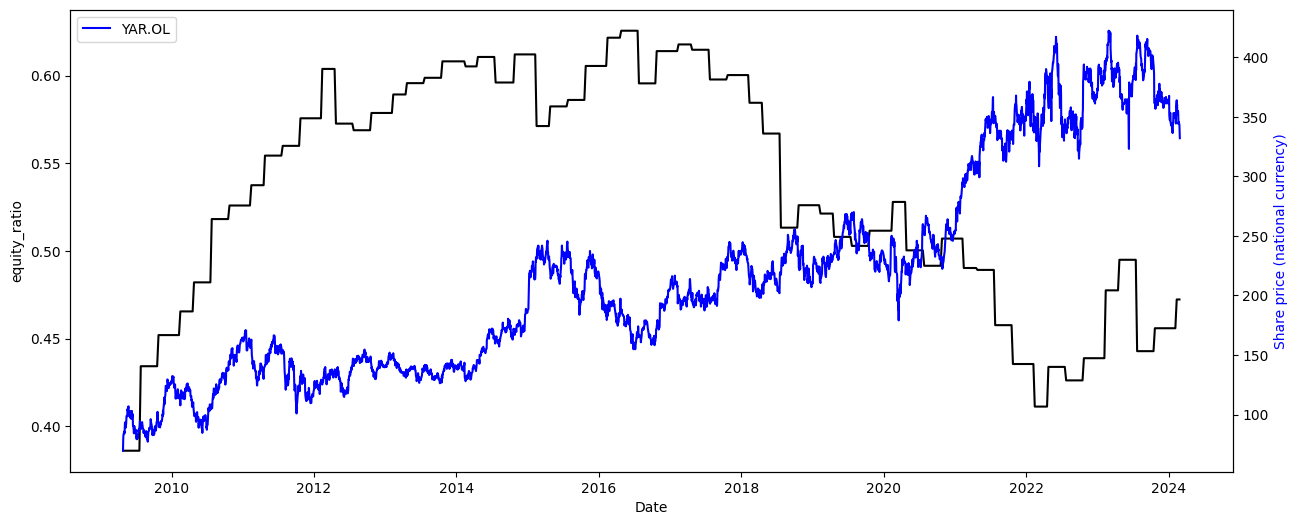

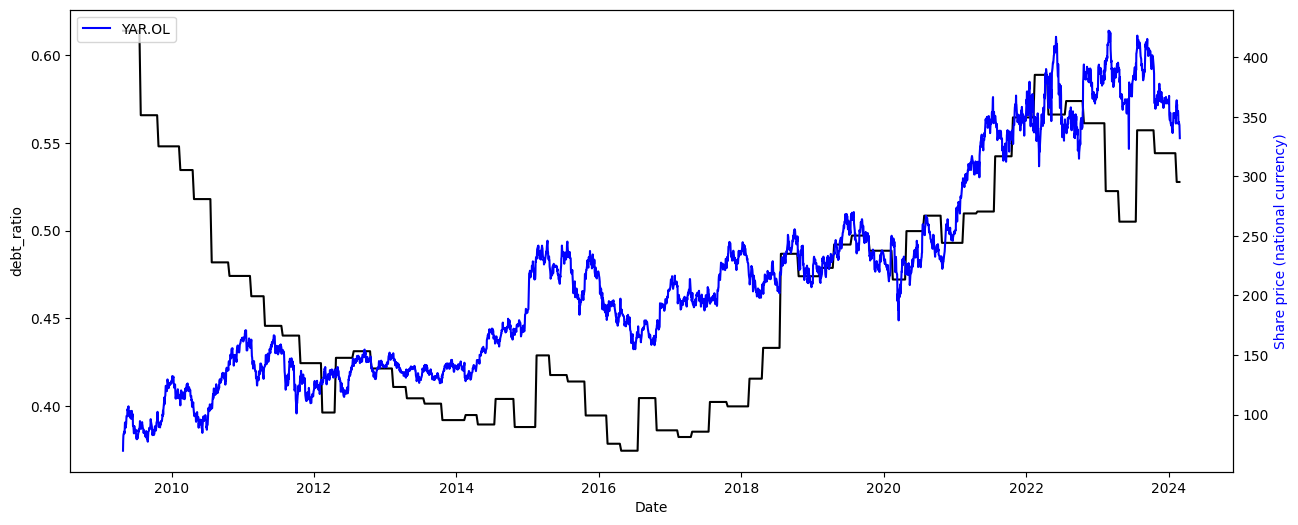

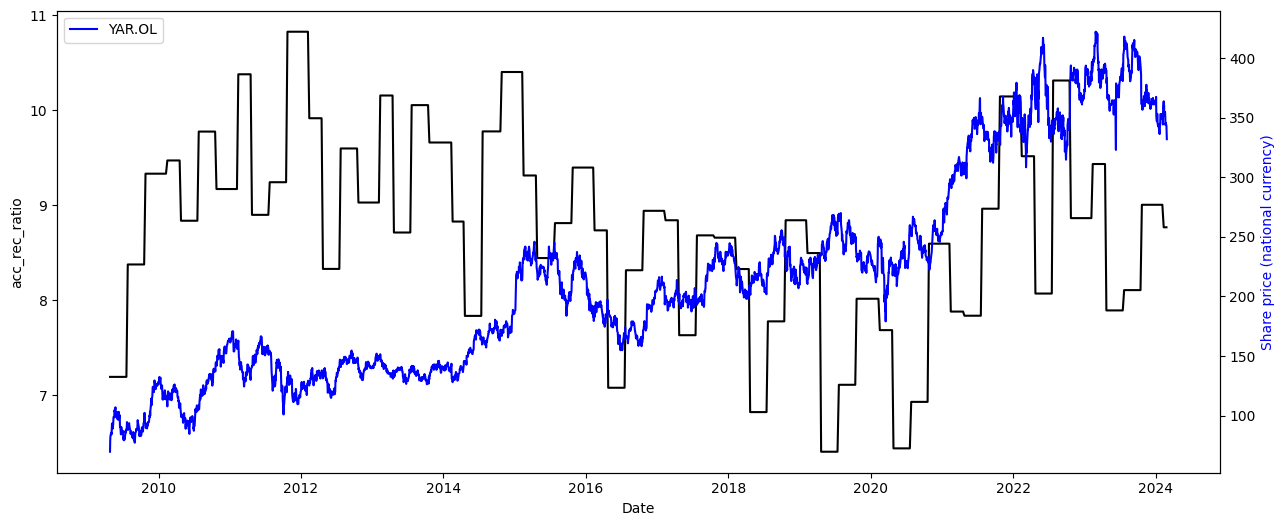

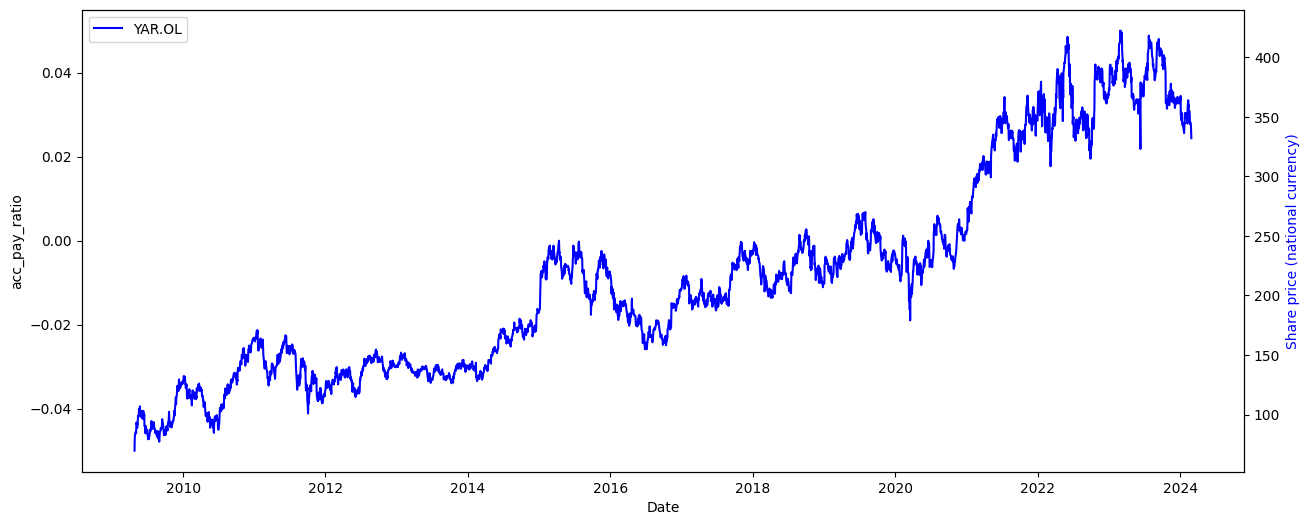

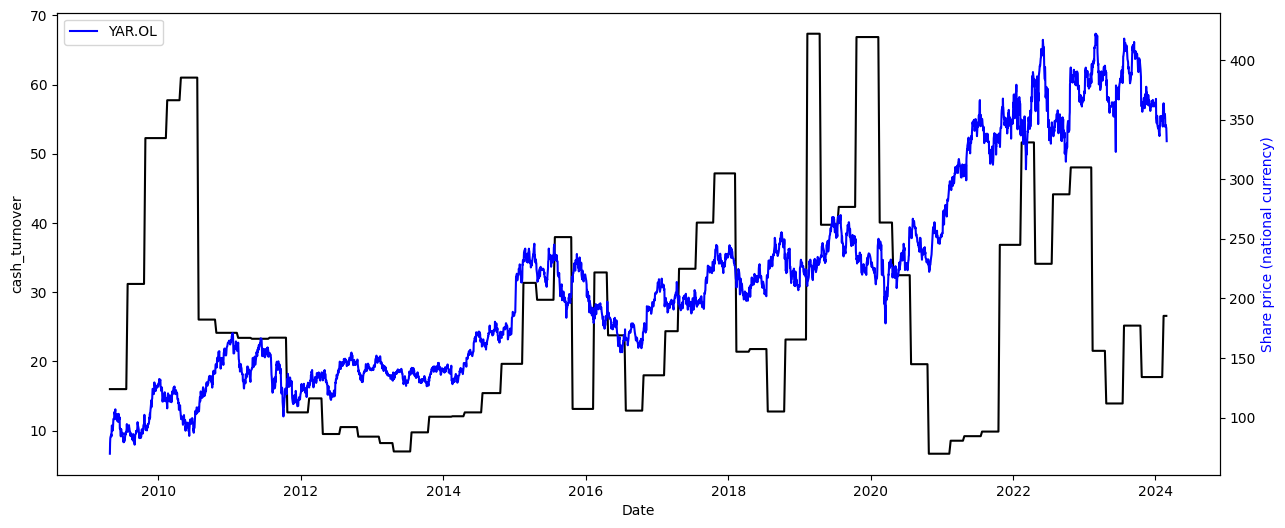

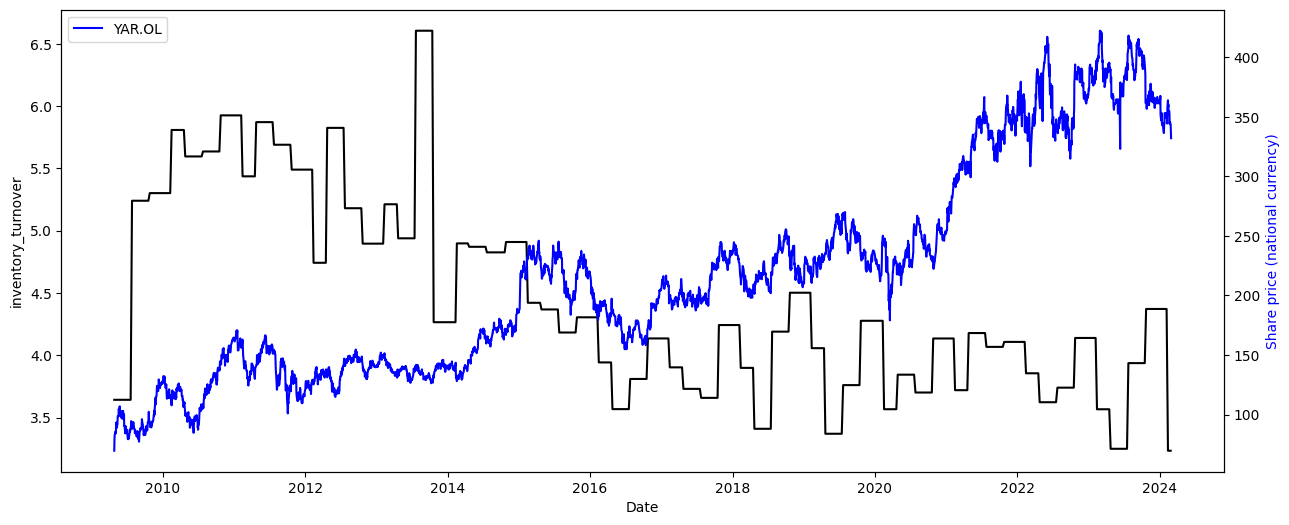

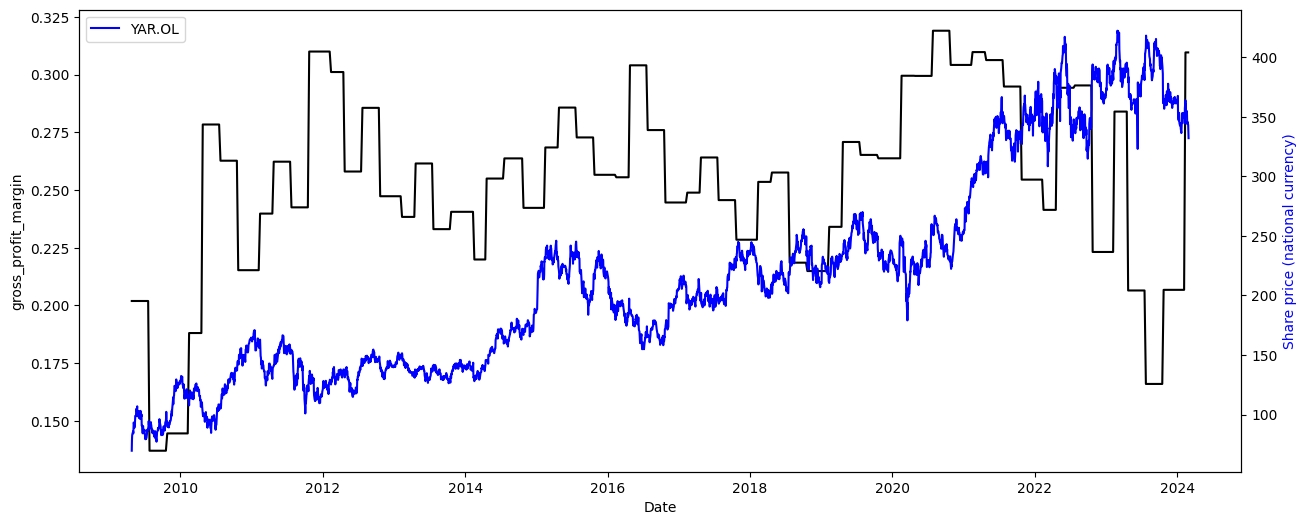

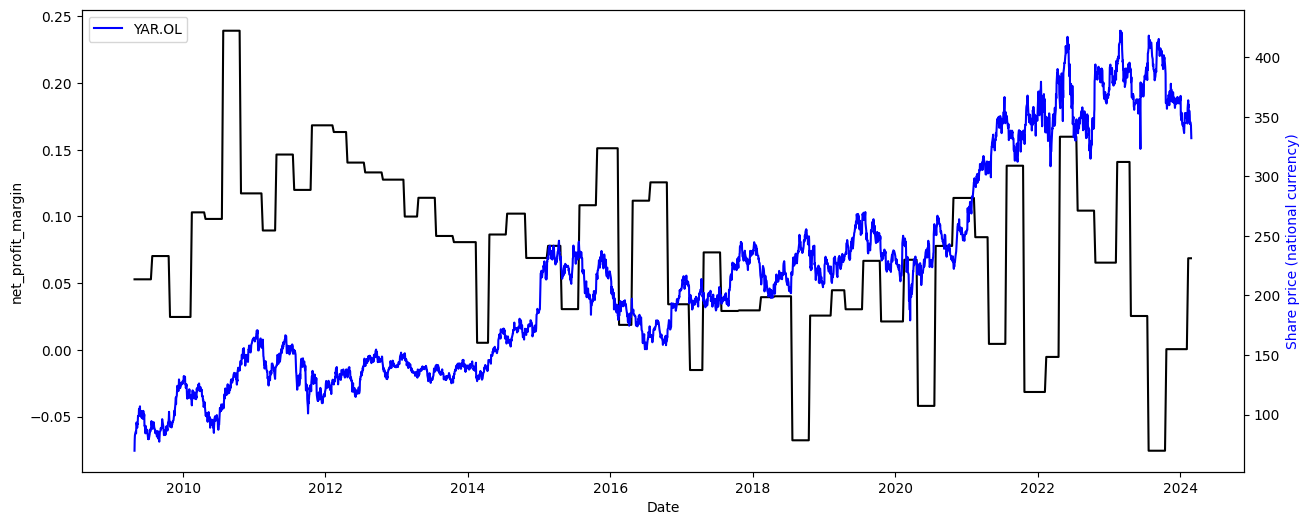

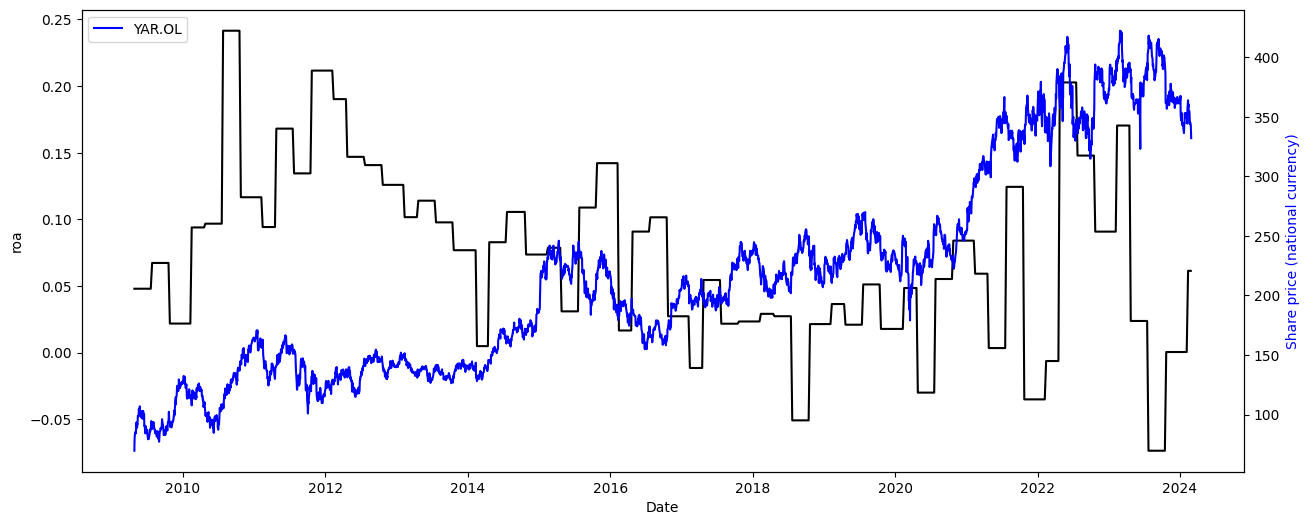

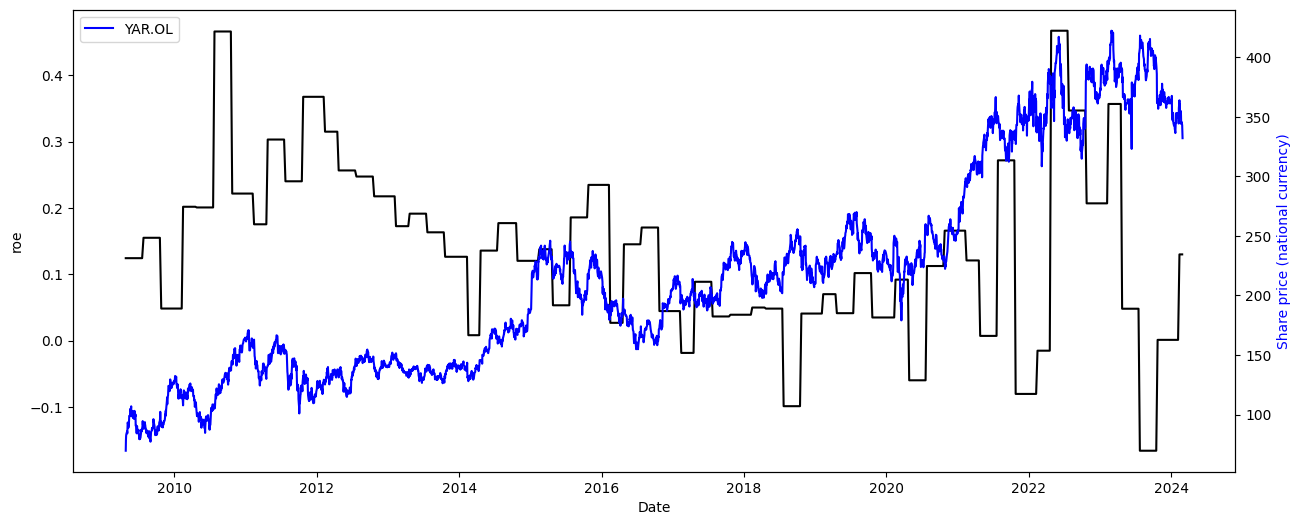

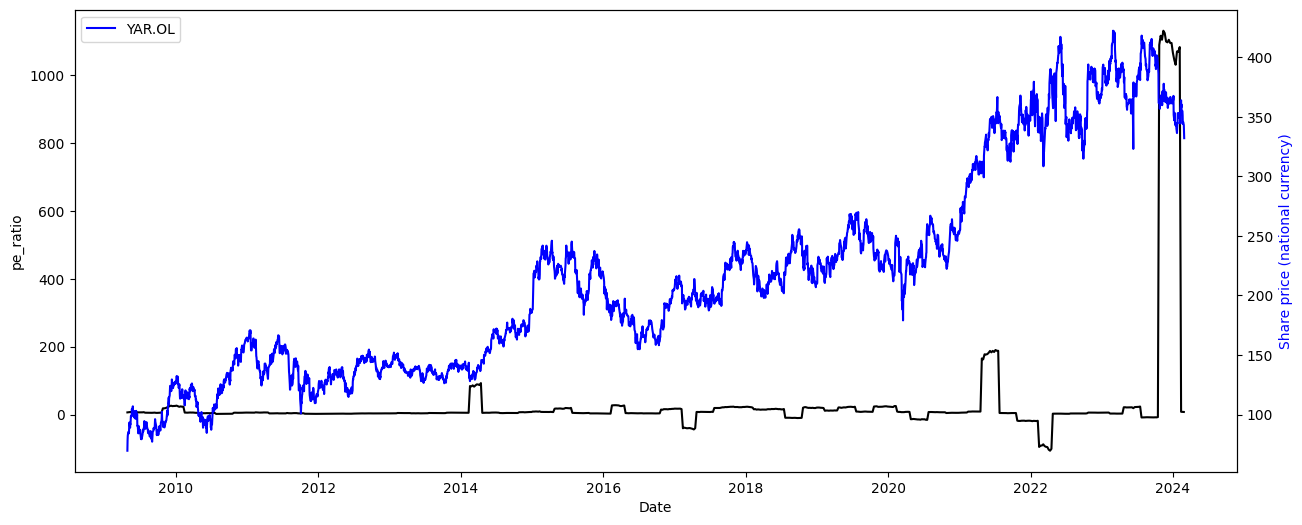

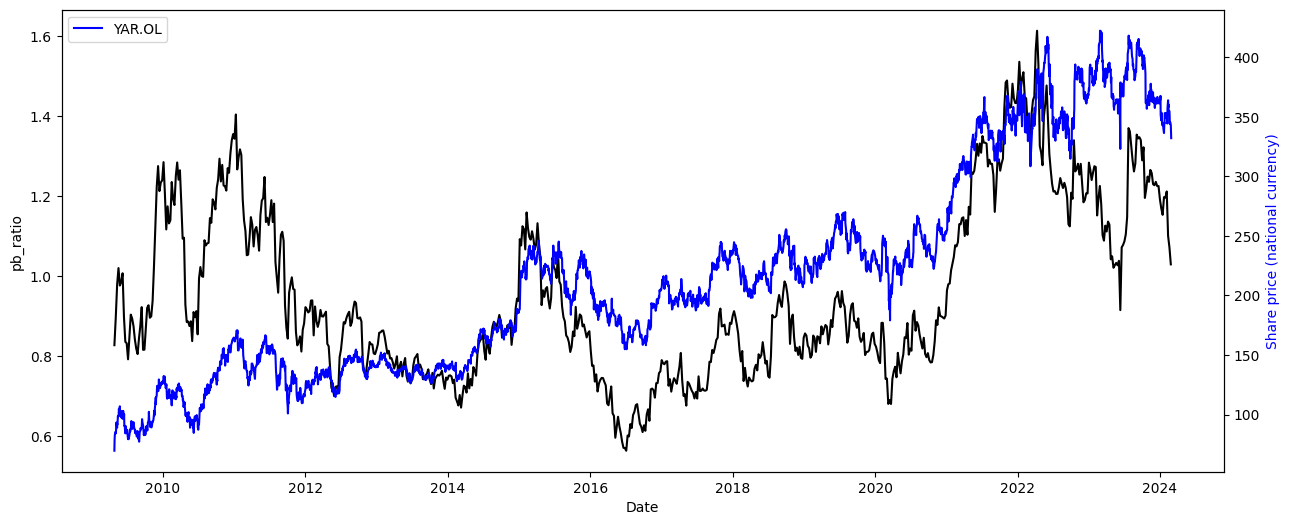

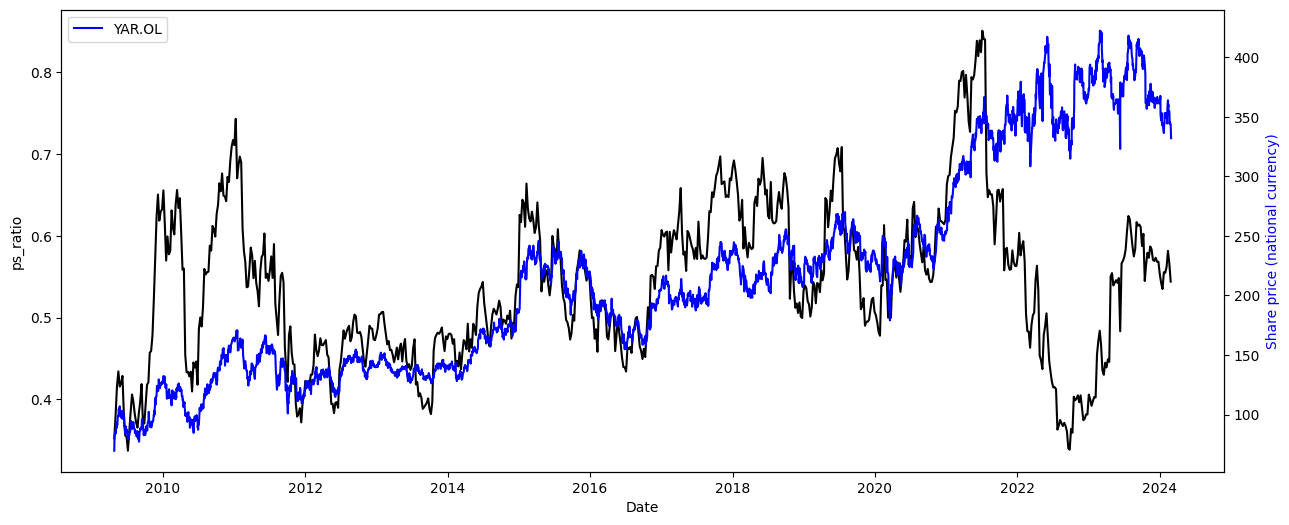

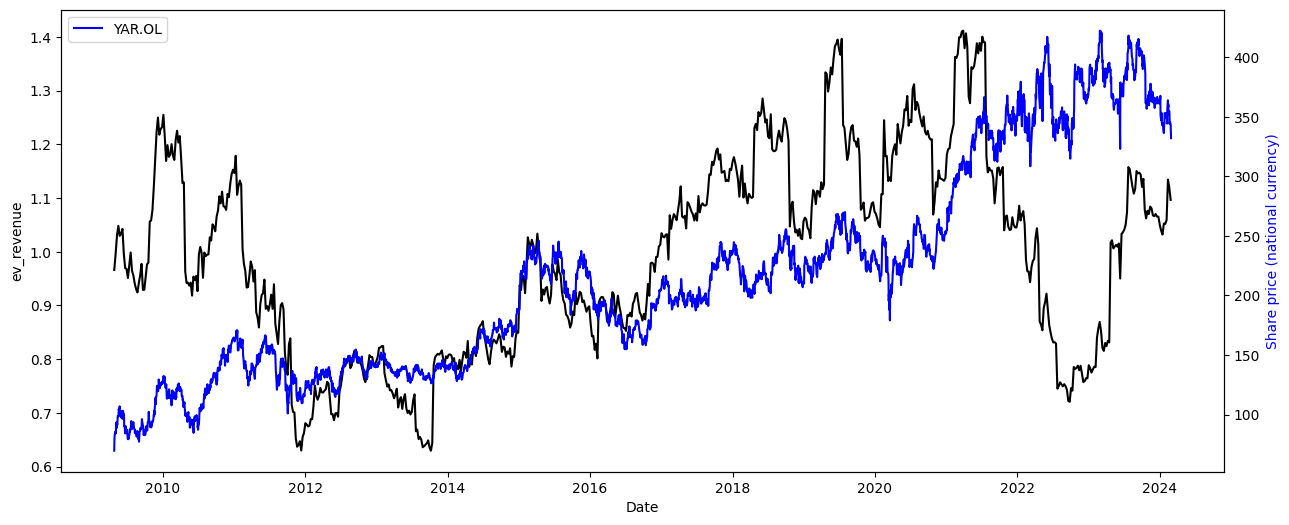

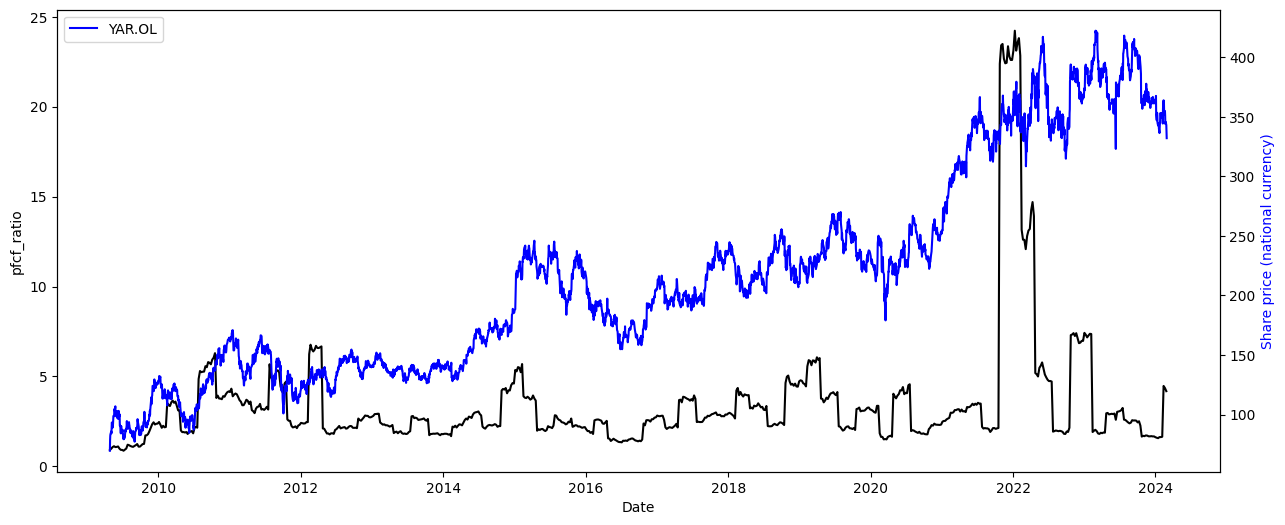

In [17]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

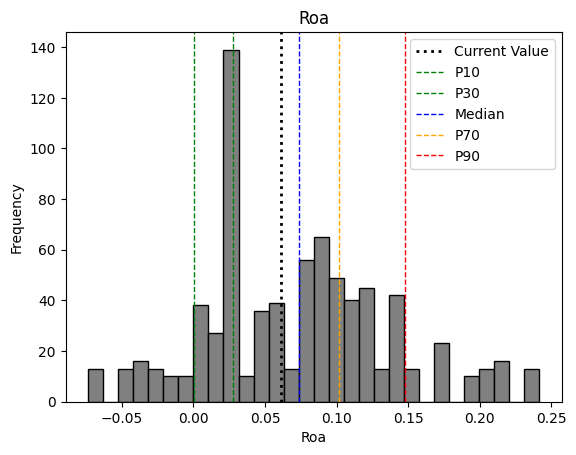

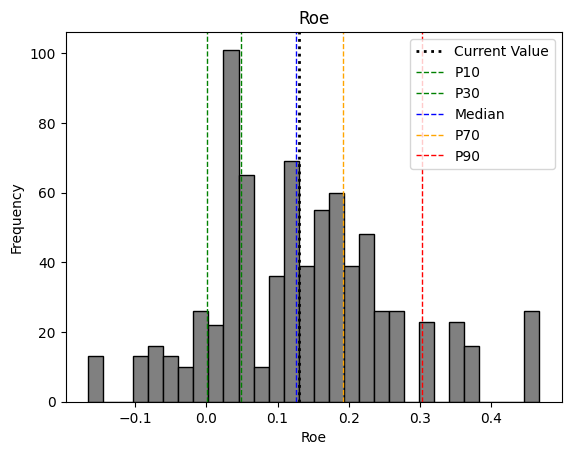

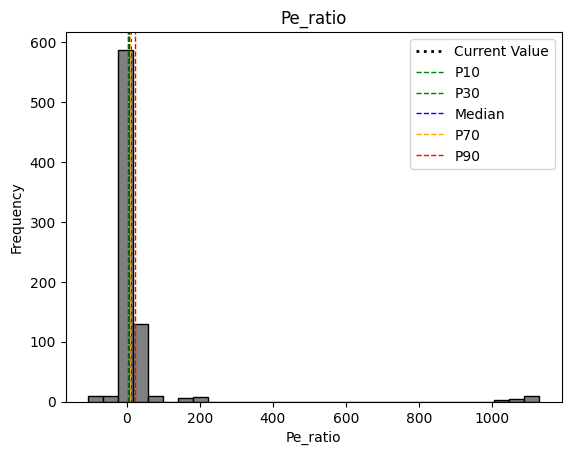

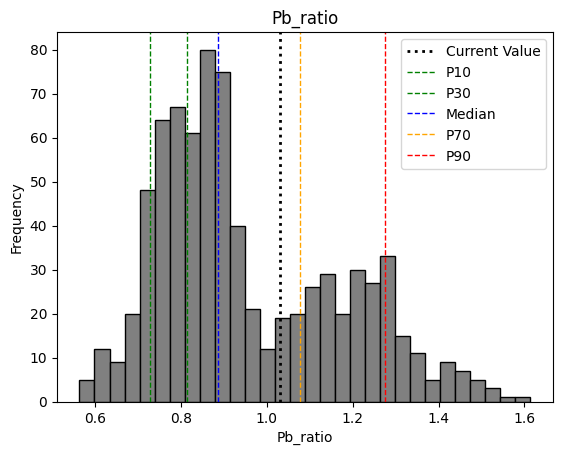

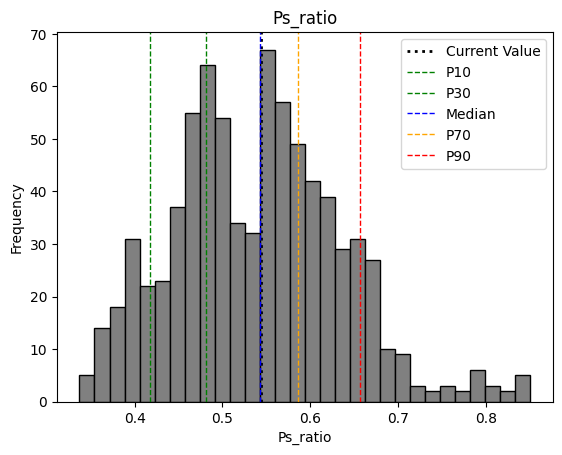

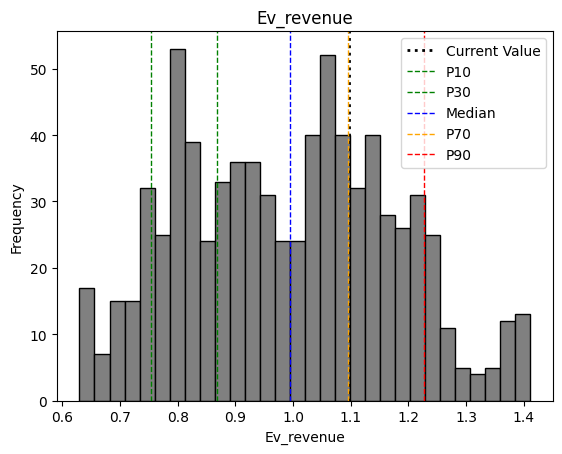

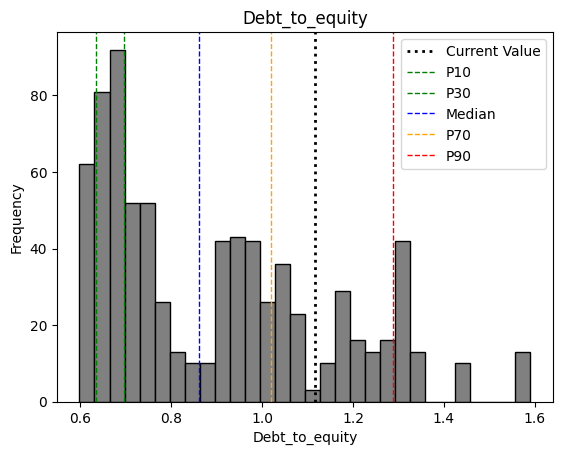

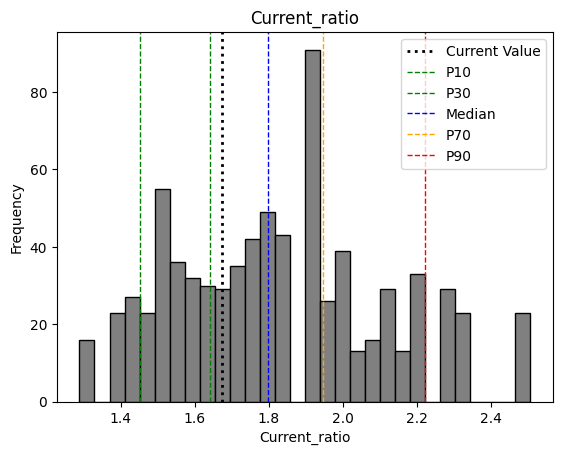

In [18]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [19]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.984427,-0.173861,0.002483,-0.398273,-0.583335,-0.177408,0.452223
roe,0.984427,1.000000,-0.165156,0.076257,-0.399323,-0.530265,-0.049922,0.354465
pe_ratio,-0.173861,-0.165156,1.000000,0.166864,0.096205,0.097780,0.148720,-0.018093
pb_ratio,0.002483,0.076257,0.166864,1.000000,0.290881,0.225180,0.683403,-0.345988
ps_ratio,-0.398273,-0.399323,0.096205,0.290881,1.000000,0.831737,-0.047072,-0.236273
ev_revenue,-0.583335,-0.530265,0.097780,0.225180,0.831737,1.000000,0.300018,-0.520449
debt_to_equity,-0.177408,-0.049922,0.148720,0.683403,-0.047072,0.300018,1.000000,-0.497533
current_ratio,0.452223,0.354465,-0.018093,-0.345988,-0.236273,-0.520449,-0.497533,1.000000


3 timestemos have been found!


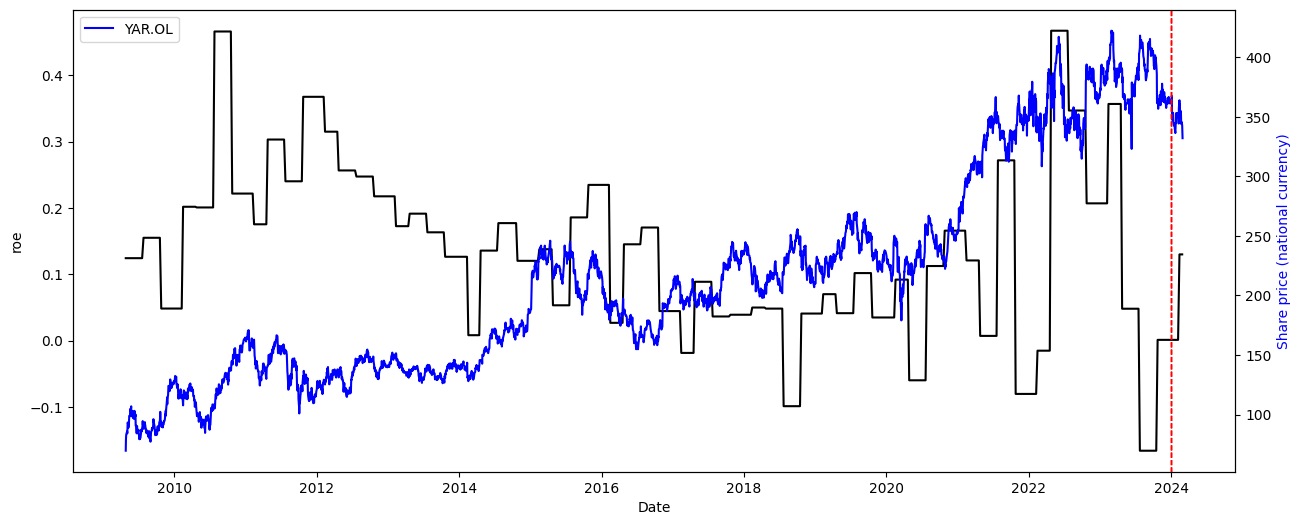

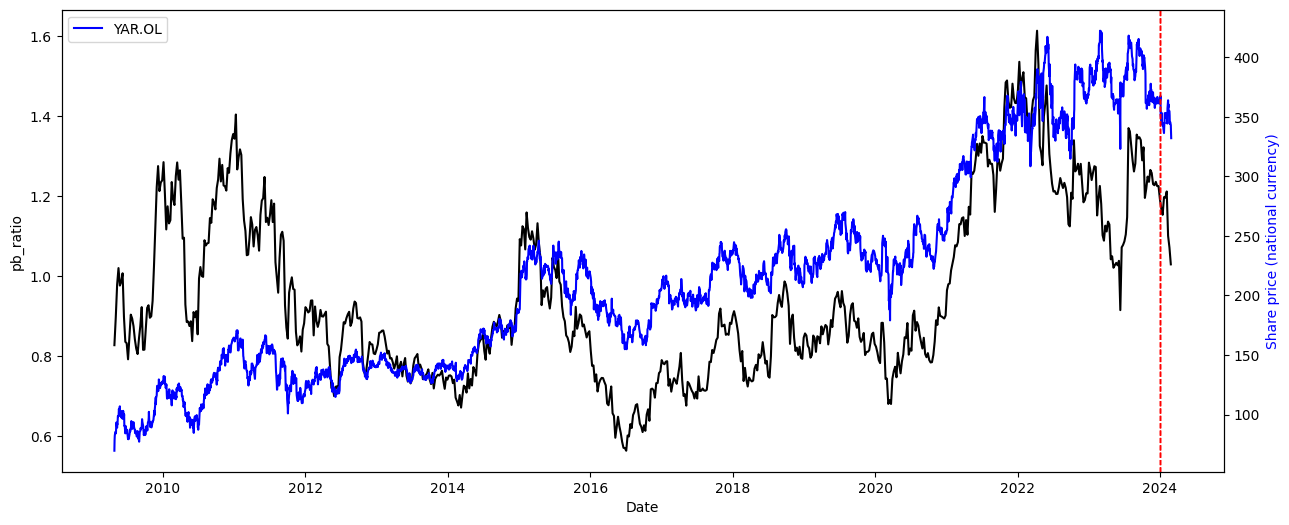

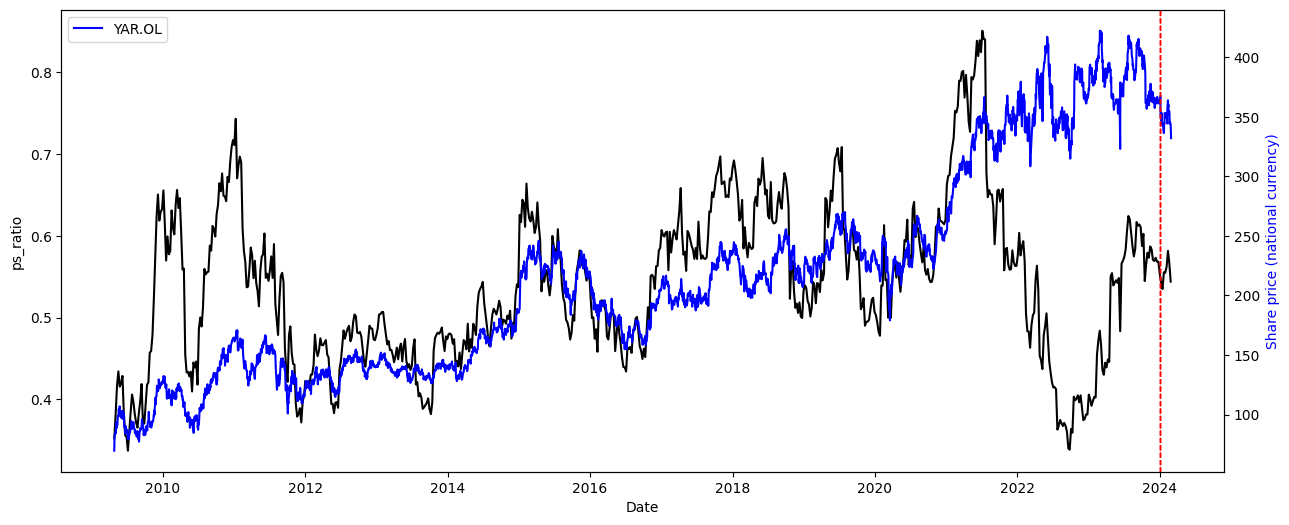

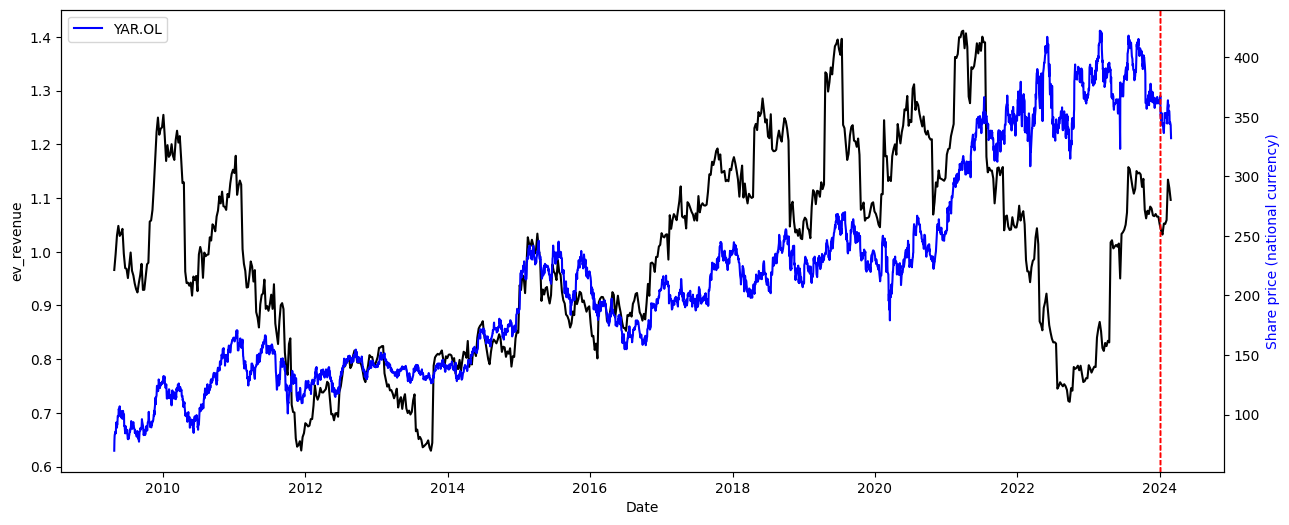

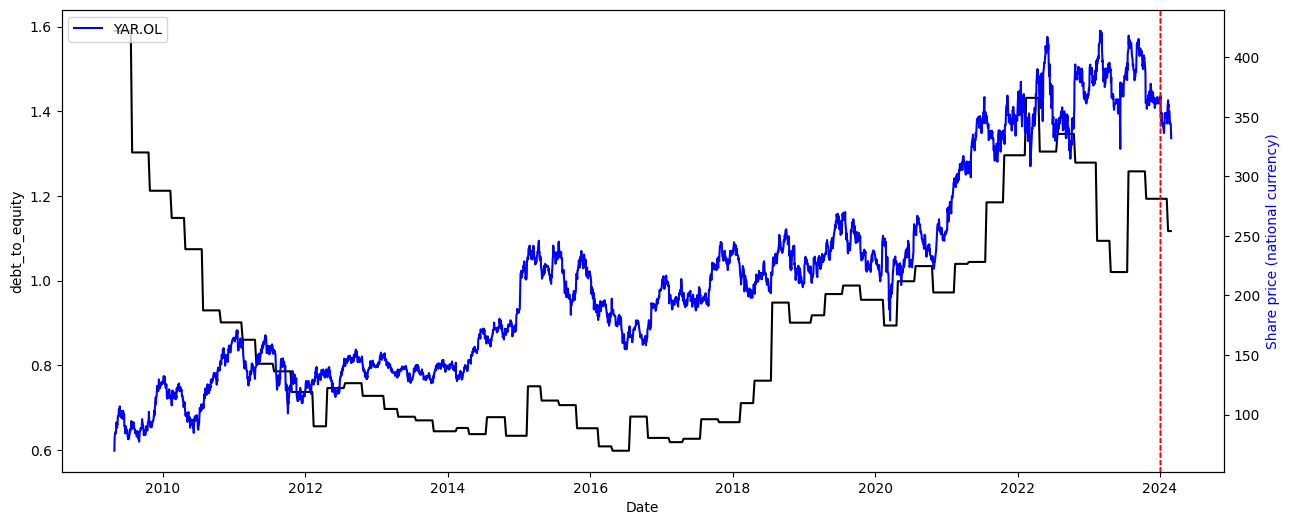

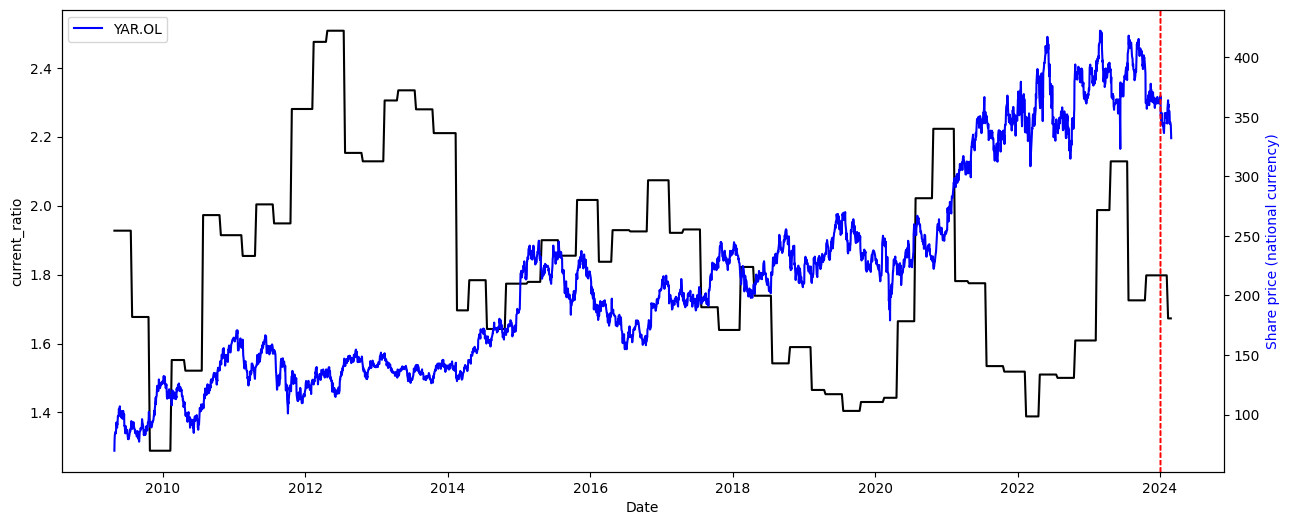

In [20]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )